<a href="https://colab.research.google.com/github/cristinarainich/MLTSA22_KRainich/blob/main/HW8/KR_HW8_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pylab as pl
from scipy import stats 
from scipy.stats import linregress
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared
import george
from george import kernels
from scipy.optimize import minimize

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install george

## I Data acquisition

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install kaggle

In [ ]:
!pwd

/content


In [ ]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [ ]:
!ls .kaggle

kaggle.json


In [ ]:
cd /content/gdrive/MyDrive/.kaggle

/content/gdrive/MyDrive/.kaggle


In [ ]:
!chmod 600 kaggle.json

In [ ]:
import json
import os
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [ ]:
os.environ

environ({'CUDNN_VERSION': '8.0.5.39', 'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64', 'CLOUDSDK_PYTHON': 'python3', 'LANG': 'en_US.UTF-8', 'HOSTNAME': '5aa42357f314', 'OLDPWD': '/', 'CLOUDSDK_CONFIG': '/content/.config', 'NVIDIA_VISIBLE_DEVICES': 'all', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2\\""],"debugAdapterMultiplexerPath":"/usr/local/bin/dap_multiplexer","enableLsp":true}', 'ENV': '/root/.bashrc', 'NCCL_VERSION': '2.7.8', 'TF_FORCE_GPU_ALLOW_GROWTH': 'true', 'NO_GCE_CHECK': 'False', 'PWD': '/', 'HOME': '/root', 'LAST_FORCED_REBUILD': '20220407', 'DEBIAN_FRONTEND': 'noninteractive', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'GCE_METADATA_TIMEOUT': '3', 'GLIBCPP_FORCE_NEW': '1', 'TBE_CREDS_ADDR': '172.28.0.1:8008', 'SHELL': '/bin/bash', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'PYTHONWARNINGS': 'ignore:::pip._internal.cli.base_command', 'CUDA_VERSION': '11.1.1', 'NVID

In [ ]:
cd /content/gdrive/MyDrive/MLTSA22/HW7

/content/gdrive/MyDrive/MLTSA22/HW7


In [ ]:
#!kaggle competitions download -c PLAsTiCC-2018

In [ ]:
!ls /content/gdrive/MyDrive/MLTSA22/HW7

data_note.pdf	       test_set_batch3.csv  test_set.csv
PLAsTiCC-2018.zip      test_set_batch4.csv  test_set_metadata.csv
sample_submission.csv  test_set_batch5.csv  test_set_sample.csv
test_set_batch10.csv   test_set_batch6.csv  training_set.csv
test_set_batch11.csv   test_set_batch7.csv  training_set_metadata.csv
test_set_batch1.csv    test_set_batch8.csv
test_set_batch2.csv    test_set_batch9.csv


In [ ]:
#!unzip PLAsTiCC-2018.zip

In [ ]:
metadata = pd.read_csv('training_set_metadata.csv')
lcvs = pd.read_csv('training_set.csv')

In [ ]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


## II Data preparation

To come up with a common time stamps for all observations, we could view each time point as a difference from the min value for particular object in particular band. I've been reading about standartization and normalization of data here: https://machinelearningmastery.com/normalize-standardize-time-series-data-python/, but we would like to save the flux values for now. Thus, we can substract from each of the observation values the min for now.  

In [ ]:
bands = lcvs["passband"].unique()
ids = lcvs['object_id'].unique()
print("Passbands (filter) identifiers:", bands)
print("Number of objects:", ids.shape[0])

Passbands (filter) identifiers: [2 1 3 4 5 0]
Number of objects: 7848


In [ ]:
new_timeline = lcvs.groupby(['object_id','passband'], as_index = False)['mjd'].apply(lambda x: x - x.min())
lcvs['new_time'] = new_timeline.values

In [ ]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected,new_time
0,615,59750.4229,2,-544.810303,3.622952,1,0.0000
1,615,59750.4306,1,-816.434326,5.553370,1,0.9515
2,615,59750.4383,3,-471.385529,3.801213,1,1.9494
3,615,59750.4450,4,-388.984985,11.395031,1,2.9573
4,615,59752.4070,2,-681.858887,4.041204,1,3.9973


Now let's standardize flux and flux_err values for further interpolation.

In [ ]:
standardization = lambda x: (x - x.mean()) / x.std()
lcvs_standard = lcvs.groupby(["object_id", "passband"])[["flux", "flux_err"]].transform(standardization)

In [ ]:
lcvs_stand = pd.concat([lcvs['object_id'], lcvs_standard, lcvs['passband'], lcvs['mjd'], lcvs['new_time']], axis = 1)

In [ ]:
lcvs_stand

,object_id,flux,flux_err,passband,mjd,new_time
0,615,-0.902317,0.418659,2,59750.4229,0.0000
1,615,-0.715759,0.449062,1,59750.4306,0.9515
2,615,-1.044293,1.327275,3,59750.4383,1.9494
3,615,-1.141283,6.976464,4,59750.4450,2.9573
4,615,-1.203442,1.140287,2,59752.4070,3.9973
...,...,...,...,...,...,...
1421700,130779836,-0.320627,-0.123199,4,60555.9838,799.9412
1421701,130779836,-0.593104,-0.586156,1,60560.0459,820.7132
1421702,130779836,-0.474355,-0.462467,5,60571.0225,830.6525
1421703,130779836,-0.319136,-0.144460,4,60585.9974,831.6485


## III Gaussian processing interpolation

In [ ]:
y = lcvs_stand.flux
kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(0.5), 
                                     kernels.CosineKernel(1))
gp = george.GP(kernel)

We also need to understand the limits of our time space.

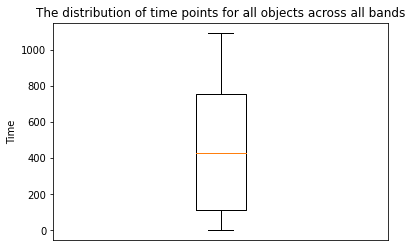

In [ ]:
pl.boxplot(lcvs_stand.new_time);
pl.title('The distribution of time points for all objects across all bands');
pl.ylabel('Time');
pl.xticks([]);

Fig. 1. The distribution of time points for all the astrological objects and all bands. As we can see, the last time point is somewhat greater than 1000, whereas the majority of time observations are in between 200th and 800th time points. 

<font color="red"> FBB :-) astronomical not astrological :-) </font>

In [ ]:
lcvs_stand.new_time.quantile([0.25,0.75])

0.25    113.6645
0.75    752.9462
Name: new_time, dtype: float64

In [ ]:
lcvs_stand.new_time.max()

1094.0023999999976

In [ ]:
lcvs_stand.new_time.unique().shape

(432186,)

The upper 3rd quartile of the length of all the time series is at 752. So, interpolate the data we could use 800 as the upper limit for our time series so that not to cut most of our data.However, when I tried it, I didn't like that we don't use all the data, so I've changed the upper limit to 1000. We're still cutting some data points, but it's limited amount. As for the samples, we have quite a lot of unique observations. But if we choose a large number, then our process will 'overfit' and interpolate data all too well and be sensitive to the possible outliers. I've chosen 500 because 1000 was too much, and 100 seemed too little.

In [ ]:
upper_limit = 1000
samples = 500
t_pred = np.linspace(0, upper_limit, samples)

Let's check how the data will be interpolated for one of the astrological objects.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexe

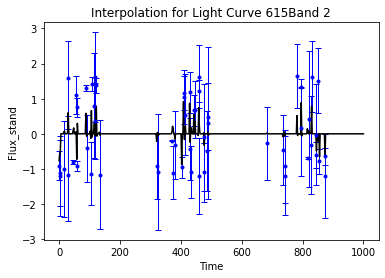

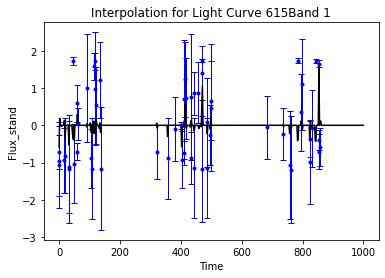

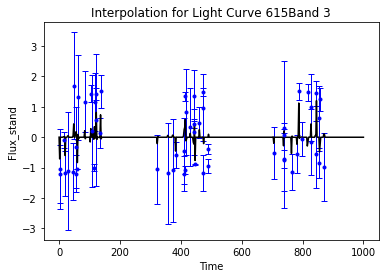

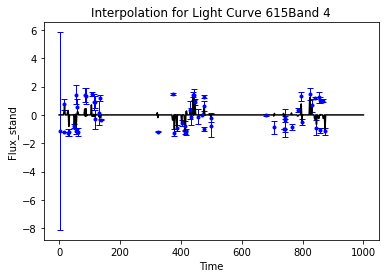

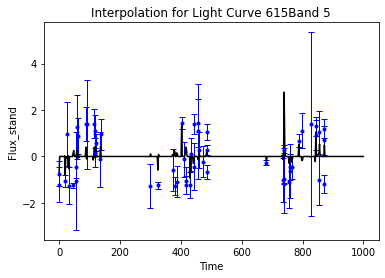

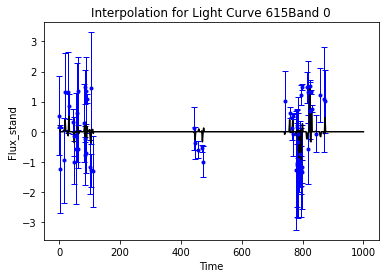

In [ ]:
for i in ids[:1]:
  for band in bands:
    subset = lcvs_stand[lcvs_stand['object_id'] == i][lcvs_stand['passband'] == band]
    t = subset.new_time
    y = subset.flux
    yerr = subset.flux_err

    gp.compute(t, yerr)
    pred, pred_var = gp.predict(y, t_pred, return_var=True)
   
    pl.figure();
    pl.errorbar(t, y, yerr, fmt='.', color='b', elinewidth=1, capsize=3)
    pl.plot(t_pred, pred, 'k');
    pl.title('Interpolation for Light Curve ' + str(i) + ' Band ' + str(band))
    pl.xlabel('Time')
    pl.ylabel('Flux_stand');


Fig. 2. The interpolation of data for one astrological object for different bands. We can see that gaussian process is trying to mimic the tendencies in flux. It interpolates zeroes in between the time groups which is okay based on the data.

<font color="red"> FBB again here astronomical - your GP is not working at all, for what I can see it just returns 0's everywhere</font>

## IV. Saving the data

We will create the dataset where each row corresponds to part object and band, i.e. row 1 would be object 615 1st band and etc.

In [ ]:
ids = ids.tolist()
bands = bands.tolist()

In [ ]:
df = np.zeros((len(ids)*len(bands), samples))

In [ ]:
df.shape

(47088, 500)

In [ ]:
for i in ids:
  for band in bands:
    subset = lcvs_stand[lcvs_stand['object_id'] == i][lcvs_stand['passband'] == band]
    t = subset.new_time
    y = subset.flux
    yerr = subset.flux_err

    gp.compute(t, yerr)
    pred, pred_var = gp.predict(y, t_pred, return_var=True)
    pos1 = ids.index(i)
    pos2 = bands.index(band)
    df[pos1 + pos2] = pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df

array([[-7.63629284e-01, -5.74473349e-01, -5.12947255e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.40456601e+00, -2.02854956e-03, -1.46331871e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.07317223e-01,  1.84563072e-02,  2.95976677e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
cd /content/gdrive/MyDrive/MLTSA22/HW7

/content/gdrive/MyDrive/MLTSA22/HW7


In [ ]:
np.savetxt('data_after.csv', df, delimiter=',')